# Calculate median weekly trends in snowlines for all sites

In [1]:
import os
import glob
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import sys
from scipy.stats import iqr
from shapely import wkt
import seaborn as sns
import contextily as ctx
import numpy as np

## Define paths in directory, import functions

In [2]:
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping-application/'
figures_out_path = os.path.join(base_path, 'figures')
sys.path.append(os.path.join(base_path, 'functions'))
import model_analyze_utils as f

scm_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/'

## Load compiled glacier boundaries (AOIs) and snowlines

In [3]:
# -----Load AOIs
aois_fn = os.path.join(scm_path, 'compiled_data', 'all_aois_climate_cluster.shp')
aois = gpd.read_file(aois_fn)
print('All glacier boundaries loaded from file.')

# -----Load snowlines
snowlines_fn = os.path.join(scm_path, 'compiled_data', 'all_snowlines.csv')
snowlines = pd.read_csv(snowlines_fn)
print('All snowlines loaded from file.')

All glacier boundaries loaded from file.
All snowlines loaded from file.


/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_6687/1505272600.py:8: DtypeWarning: Columns (13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  snowlines = pd.read_csv(snowlines_fn)


## Calculate weekly median trends for each site

In [4]:
snowlines_medians_fn = os.path.join(scm_path, 'results', 'all_snowlines_weekly_median_trends.csv') 
if not os.path.exists(snowlines_medians_fn):
    # add week-of-year (WOY column to snowlines
    snowlines['datetime'] = pd.to_datetime(snowlines['datetime'], format='mixed')
    snowlines['WOY'] = snowlines['datetime'].dt.isocalendar().week
    # determine columns to calculate weekly stats
    columns = ['AAR', 'snowline_elevs_median_m', 'SCA_m2', 'ELA_from_AAR_m']
    snowlines_medians = pd.DataFrame()
    for site_name in tqdm(snowlines['site_name'].drop_duplicates().values):
        # subset snowlines to site
        snowlines_site = snowlines.loc[snowlines['site_name']==site_name]
        # calculate weekly quartile trends
        q1 = snowlines_site[['WOY'] + columns].groupby(by='WOY').quantile(0.25)
        q1.columns = [x + '_P25' for x in q1.columns]
        q2 = snowlines_site[['WOY'] + columns].groupby(by='WOY').quantile(0.5)
        q2.columns = [x + '_P50' for x in q2.columns]
        q3 = snowlines_site[['WOY'] + columns].groupby(by='WOY').quantile(0.75)
        q3.columns = [x + '_P75' for x in q3.columns]
        qs = pd.merge(q1, pd.merge(q2, q3, on='WOY'), on='WOY')
        qs = qs.reindex(sorted(qs.columns), axis=1)
        qs['WOY'] = qs.index
        qs['site_name'] = site_name
        # concatenate to medians dataframe
        snowlines_medians = pd.concat([snowlines_medians, qs])
    # save to file
    snowlines_medians.to_csv(snowlines_medians_fn, index=False)
    print('Median weekly snow trends saved to file: ', snowlines_medians_fn)
        
else:
    snowlines_medians = pd.read_csv(snowlines_medians_fn)
    print('Median weekly snow trends loaded from file.')
    
snowlines_medians
        

Median weekly snow trends loaded from file.


,AAR_P25,AAR_P50,AAR_P75,ELA_from_AAR_m_P25,ELA_from_AAR_m_P50,ELA_from_AAR_m_P75,SCA_m2_P25,SCA_m2_P50,SCA_m2_P75,snowline_elevs_median_m_P25,snowline_elevs_median_m_P50,snowline_elevs_median_m_P75,WOY,site_name
0,0.960559,0.987424,0.991828,1411.189450,1414.29630,1467.113000,13407550.0,13564400.0,13742750.0,1402.4318,1402.43180,1402.43180,17,RGI60-01.00032
1,0.948967,0.978006,0.996441,1407.899950,1429.58410,1490.872150,12004750.0,12527900.0,13220200.0,1402.4318,1402.43180,1402.81405,18,RGI60-01.00032
2,0.855447,0.911041,0.971798,1443.832775,1552.28490,1628.433475,10448150.0,12010500.0,12786050.0,1402.4318,1402.43180,1410.96095,19,RGI60-01.00032
3,0.882326,0.924096,0.961707,1465.554850,1534.14715,1591.236950,10939450.0,12702400.0,13200150.0,1402.4318,1402.81405,1405.45240,20,RGI60-01.00032
4,0.854095,0.943413,0.971476,1444.811200,1503.61800,1631.832300,10631400.0,12268300.0,12988975.0,1403.1963,1405.33490,1427.41415,21,RGI60-01.00032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5268,0.420369,0.728382,0.923667,2395.542600,2439.00000,2504.500000,509950.0,819000.0,1008700.0,2387.1876,2472.29200,2621.13915,40,RGI60-02.16722
5269,0.414888,0.449922,0.960265,2386.000000,2497.00000,2506.384800,503300.0,545800.0,841000.0,2449.0730,2481.12060,2520.29080,41,RGI60-02.16722
5270,0.693314,0.926846,0.963769,2385.147350,2395.00000,2446.910400,818350.0,1099900.0,1154800.0,2445.0495,2527.41020,2649.60190,42,RGI60-02.16722
5271,0.961380,0.974180,0.995053,2359.500000,2382.50000,2386.000000,992750.0,1138300.0,1167150.0,2346.7144,2346.71440,2400.21310,43,RGI60-02.16722


In [5]:
# -----Compile RGI characteristics and minimum snow cover median statistics
min_snow_cover_stats_fn = os.path.join(scm_path, 'results', 'min_snow_cover_stats.csv') 
# check if exists in directory
if not os.path.exists(min_snow_cover_stats_fn):
    # initialize dataframe for RGI stats and minimum snow cover statts
    min_snow_cover_stats = pd.DataFrame()
    
    # iterate over site names in median snowlines dataframe
    for site_name in tqdm(sorted(snowlines_medians['site_name'].drop_duplicates().values)):
        # grab AOI for site
        aoi_site = aois.loc[aois['RGIId']==site_name, :]
        # grab median snowline stats for site
        snowlines_medians_site = snowlines_medians.loc[snowlines_medians['site_name']==site_name, :]
        # calculate min median stats
        median_columns = [x for x in snowlines_medians.columns if 'P50' in x]
        for column in median_columns:
            if (column=='ELA_from_AAR_m_P50') or (column=='snowline_elevs_median_m_P50'):
                aoi_site[column+'_max'] = snowlines_medians_site[column].max()
            else:
                aoi_site[column+'_min'] = snowlines_medians_site[column].min()
        # concatenate to full dataframe
        min_snow_cover_stats = pd.concat([min_snow_cover_stats, aoi_site])

    # add subregion names and colors
    min_snow_cover_stats[['Subregion', 'color']] = '', ''
    min_snow_cover_stats[['O1Region', 'O2Region']] = min_snow_cover_stats[['O1Region', 'O2Region']].astype(int)
    for o1, o2 in min_snow_cover_stats[['O1Region', 'O2Region']].drop_duplicates().values:
        min_snow_cover_stats.loc[(min_snow_cover_stats['O1Region']==o1) 
                                 & (min_snow_cover_stats['O2Region']==o2), ['Subregion', 'color']] = f.determine_subregion_name_color(o1, o2)
    # save to file
    min_snow_cover_stats.to_csv(min_snow_cover_stats_fn, index=False)
    print('Minimum median snow cover stats saved to file: ', min_snow_cover_stats_fn)
        
else:
    # load from file
    min_snow_cover_stats = pd.read_csv(min_snow_cover_stats_fn)
    min_snow_cover_stats['geometry'] = min_snow_cover_stats['geometry'].apply(wkt.loads)
    print('Minimum median snow cover stats loaded from file.')

# reformat as GeoDataFrame
min_snow_cover_stats = gpd.GeoDataFrame(min_snow_cover_stats, crs='EPSG:4326')
min_snow_cover_stats

Minimum median snow cover stats loaded from file.


,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,centroid_x,centroid_y,cluster,clustName,geometry,AAR_P50_min,ELA_from_AAR_m_P50_max,SCA_m2_P50_min,snowline_elevs_median_m_P50_max,color
0,RGI60-01.00032,G213069E63641N,20090703,-9999999,-146.930984,63.640633,1,2,14.205,1411,...,-146.943128,63.655447,3,Continental,"POLYGON ((-146.90152 63.66425, -146.90116 63.6...",0.140864,2632.17495,1793450.0,2444.11650,#1f78b4
1,RGI60-01.00033,G213128E63680N,20090703,-9999999,-146.872000,63.680000,1,2,4.604,1109,...,-146.871977,63.680032,3,Continental,"POLYGON ((-146.84326 63.67199, -146.84262 63.6...",0.011958,2956.57200,54800.0,2998.45630,#1f78b4
2,RGI60-01.00037,G213472E63469N,20090703,-9999999,-146.528168,63.469173,1,2,234.583,722,...,-146.375259,63.449939,3,Continental,"POLYGON ((-146.40062 63.38060, -146.40321 63.3...",0.357395,1918.16000,74287800.0,1941.36000,#1f78b4
3,RGI60-01.00038,G213531E63603N,20090703,-9999999,-146.469000,63.603000,1,2,138.555,851,...,-146.469466,63.603311,3,Continental,"POLYGON ((-146.30109 63.57925, -146.30059 63.5...",0.296289,2622.26000,35172900.0,3017.53000,#1f78b4
4,RGI60-01.00046,G212723E63542N,20090703,-9999999,-147.277000,63.542000,1,2,193.423,844,...,-147.277127,63.541832,3,Continental,"POLYGON ((-147.05197 63.62237, -147.05209 63.6...",0.396437,1731.47500,71728050.0,2297.07000,#1f78b4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,RGI60-02.17736,G238150E48784N,19759999,-9999999,-121.850350,48.784220,2,4,6.834,1217,...,-121.850349,48.784220,5,Transitional-Continental,"POLYGON ((-121.88439 48.78574, -121.88431 48.7...",0.297830,2341.50000,1973750.0,2258.35045,#ff7f00
196,RGI60-02.17738,G238159E48761N,19759999,-9999999,-121.841480,48.760890,2,4,4.996,1192,...,-121.841482,48.760892,5,Transitional-Continental,"POLYGON ((-121.82020 48.77586, -121.82017 48.7...",0.677412,2131.00000,3288600.0,2057.35960,#ff7f00
197,RGI60-02.17739,G238170E48750N,19749999,-9999999,-121.829960,48.749560,2,4,2.888,1582,...,-121.829955,48.749559,5,Transitional-Continental,"POLYGON ((-121.84130 48.75010, -121.84127 48.7...",0.537035,2131.00000,1461000.0,2119.86230,#ff7f00
198,RGI60-02.17741,G238208E48771N,19759999,-9999999,-121.792480,48.770980,2,4,6.290,1412,...,-121.792478,48.770979,5,Transitional-Continental,"POLYGON ((-121.82016 48.77583, -121.82016 48.7...",0.615530,2077.50000,3669250.0,2026.87785,#ff7f00


/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/seaborn/_oldc

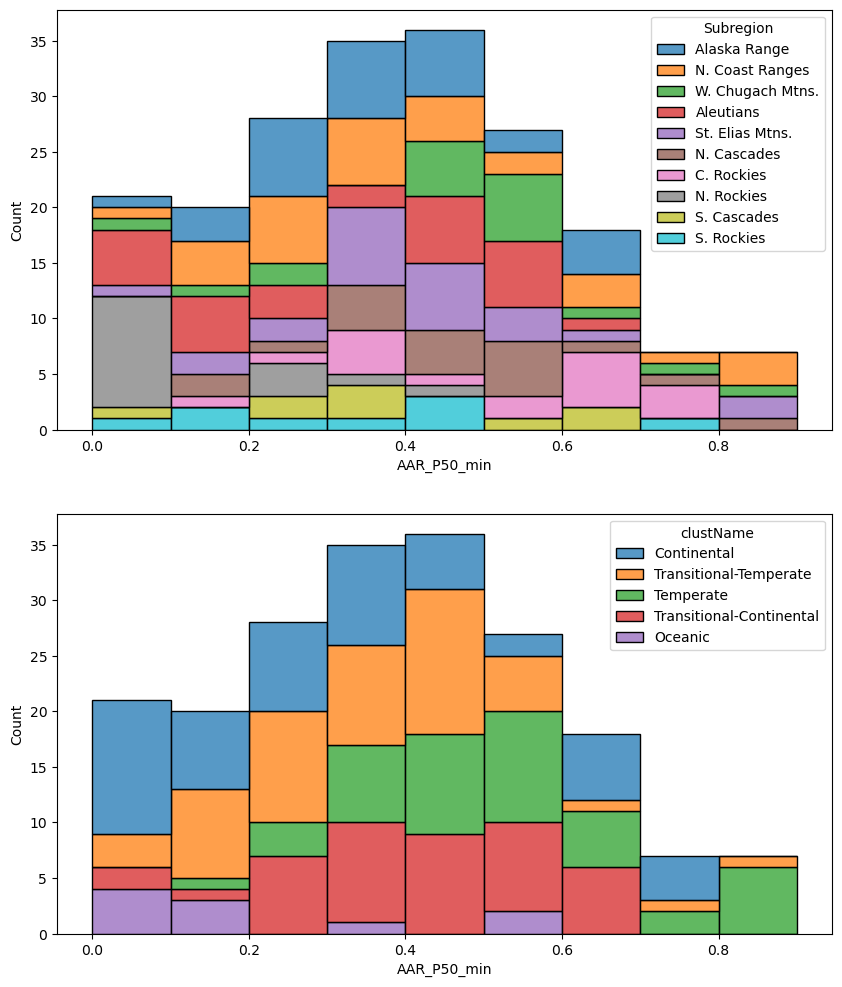

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
sns.histplot(data=min_snow_cover_stats, x='AAR_P50_min', multiple='stack', hue='Subregion', 
             bins=np.arange(0, 1, step=0.1), ax=ax[0])
sns.histplot(data=min_snow_cover_stats, x='AAR_P50_min', multiple='stack', hue='clustName', 
             bins=np.arange(0, 1, step=0.1), ax=ax[1])
plt.show()

In [10]:
# Print stats
min_snow_cover_stats.groupby(by=['Subregion', 'clustName'])['AAR_P50_min'].median().sort_values()

Subregion         clustName               
N. Rockies        Continental                 0.082234
Aleutians         Oceanic                     0.142377
St. Elias Mtns.   Continental                 0.188769
N. Coast Ranges   Transitional-Continental    0.205166
St. Elias Mtns.   Transitional-Temperate      0.234289
N. Coast Ranges   Transitional-Temperate      0.237134
Alaska Range      Continental                 0.296289
S. Rockies        Continental                 0.316286
S. Cascades       Transitional-Temperate      0.324843
W. Chugach Mtns.  Transitional-Temperate      0.325088
S. Cascades       Transitional-Continental    0.332333
Alaska Range      Transitional-Temperate      0.381113
N. Cascades       Transitional-Temperate      0.411679
St. Elias Mtns.   Transitional-Continental    0.415721
Aleutians         Transitional-Temperate      0.419095
                  Transitional-Continental    0.440611
N. Coast Ranges   Temperate                   0.456577
Alaska Range      Temp